In [7]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchsummary import summary
from torcheval.metrics import BinaryPrecisionRecallCurve
import torchmetrics
from tqdm.notebook import tqdm
from torchmetrics import R2Score
from sklearn.metrics import precision_recall_curve, f1_score, classification_report
from comet_ml import Experiment
from umap import UMAP

%matplotlib inline

In [2]:
df=pd.read_csv('datasets/data.csv')
df[['q_mu', 'q_nu1', 'q_nu2', 'e_nu_1', 'e_nu_2']]

,q_mu,q_nu1,q_nu2,e_nu_1,e_nu_2
0,0.550377,0.164911,0.008094,0.01904,0.17794
1,0.564295,0.167629,0.006639,0.01672,0.20868
2,0.564179,0.164110,0.007052,0.01337,0.20442
3,0.573555,0.167174,0.006663,0.01637,0.18453
4,0.569296,0.169658,0.006823,0.01783,0.11478
...,...,...,...,...,...
184845,0.566484,0.172819,0.008164,0.02085,0.25589
184846,0.572031,0.170474,0.007907,0.01592,0.23668
184847,0.569204,0.173147,0.007366,0.01590,0.24216
184848,0.570114,0.168854,0.007378,0.01384,0.24447


In [3]:
df['e_mu_current']

0         0.01298
1         0.01283
2         0.01268
3         0.01129
4         0.01169
           ...   
184845    0.00842
184846    0.00971
184847    0.00886
184848    0.00868
184849    0.00937
Name: e_mu_current, Length: 184850, dtype: float64

In [11]:
data=pd.read_csv('datasets/data.csv')
x = data[['q_mu', 'q_nu1', 'q_nu2', 'e_nu_1', 'e_nu_2']].values
labels=[]
matrices=[]

log_data=np.log(data['e_mu_current'])
data_std=np.std(log_data)
data_mean=np.mean(log_data)

for i, point in enumerate(log_data[5:-1]):
    if point >=2*data_std+data_mean:
        labels.append(1)
    else:
        labels.append(0)
    matrices.append(x[i:5+i,:].flatten())

labels=np.array(labels)
matrices=np.array(matrices)

In [12]:
umap_vectorier=UMAP()
embs=umap_vectorier.fit_transform(matrices)

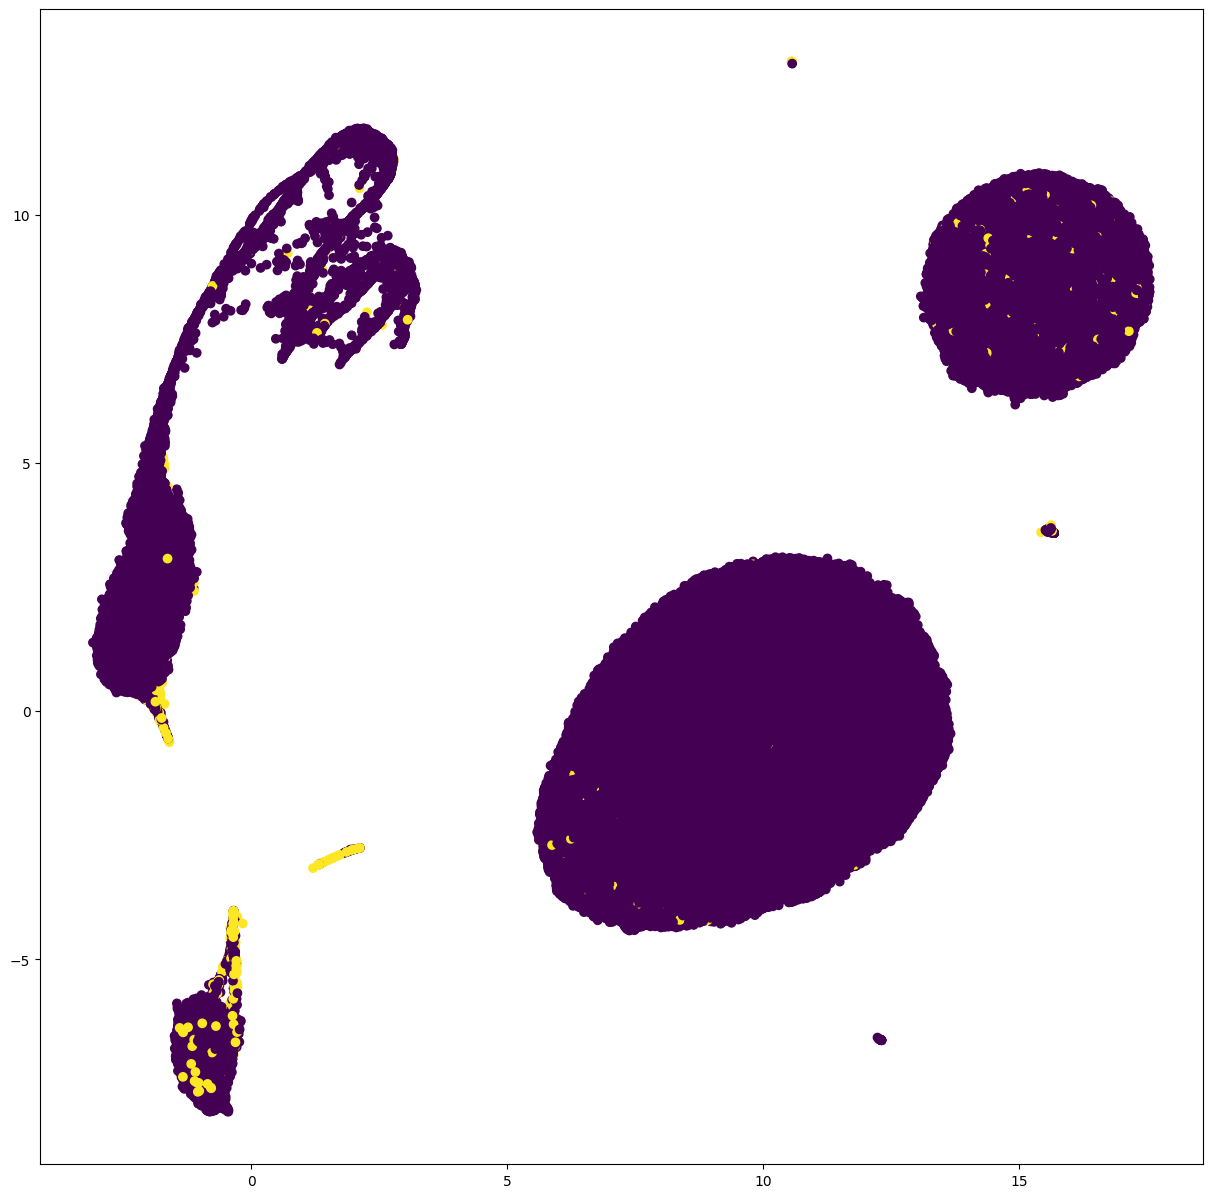

In [22]:
plt.figure(figsize=(15,15))
plt.scatter(embs[:,0],embs[:,1],c=labels*160)
plt.savefig('box_embs.png')
plt.show()

In [5]:
class BoxDataset(Dataset):
    
    @classmethod
    def __init__(self, df_path):
        self.data=pd.read_csv(df_path)
        self.x = self.data[['q_mu', 'q_nu1', 'q_nu2', 'e_nu_1', 'e_nu_2']].values
        labels=[]
        self.matrices=[]
        
        log_data=np.log(self.data['e_mu_current'])
        data_std=np.std(log_data)
        data_mean=np.mean(log_data)

        for i, point in enumerate(log_data[5:-1]):
            if point >=2*data_std+data_mean:
                labels.append(1)
            else:
                labels.append(0)
            self.matrices.append(self.x[i:5+i,:])
            
        self.labels=np.array(labels)
        
        self.labels = torch.FloatTensor(self.labels)
        self.matrices = torch.FloatTensor(self.matrices)
    def __len__(self):
        return len(self.matrices)

    def __getitem__(self, idx):
        return {'matrices':self.matrices[idx], 'labels':self.labels[idx]}

In [ ]:
em